# Final task:  Dimensionality reduction via principal component analysis

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from IPython.display import HTML
import random
import copy
import numpy as np
import scipy as scy

from tqdm.notebook import trange, tqdm
import time 
from scipy.stats import maxwell

#used for the video
import subprocess
import glob
import os

## Introduction: 

The analysis of highly dimentional systems described by a set of correlated coordinate can be very tedous, we therefore aim to simplify the system in such a way that that the anaylsis becomes computationally affordable and that the simplified model still describes the system in a revelent way.
In this simulation we are here looking at dimentionality reduction using Principal componant analysis (PCA). The initial correlated set of corrdinates are modified by calculating the covarience matrix, diagonalising it, and obtaining it's eingenvectors and eingenvalues. With this transformation we order the coordinated by oder of magnitude of their eingen values. The eigenvectors give the new coordinates and the ones with higher eingenvalues are the ones along which the varience of the system is highter, and therefore the ones that describe the pricipal motion of the system. With a system with $n$ sets of coordinates we can now choose the $m$ (with $m<<n$ ) most important ones and analyse the system in lower dimentions with this new set of coordinates.

This simulation is runed with a relatively simple system (2D) and aims to show how PCA technic can help reduce dimentions by at the same time preserving the main characteristics of the system. We are here studying a 2D potential and obtaining out data of the energy surface by implementing a Monte Carlo method with Metropolis algorithm. We will study the difference of the data in the inital coordinates (x and y) and in the new set calculated from the covarience martix $\sigma$.

## Task I: Implementation

Monte Carlo (MC) method with Metropolis algorithm that samples a 2D energy surface with:

$$U(x,y) = k_{b}T (0.28(0.25(a¬∑x+b¬∑y)^{4}+0.1(a¬∑x+b¬∑y)^{3} ‚àí3.24(a¬∑x+b¬∑y)^{2} +6.856(a¬∑y‚àíb¬∑x)^{2})+3.5)$$ 

with $a = 0.809$ and $b = 0.588$.

* Calculates the potential energy given values of x and y using the above equation.

-> Takes : x, y 

-> Returns : U(x,y)

In [2]:
def Potential_energy (x,y):
    a = 0.809
    b = 0.588

    ax_plus_by = a*x + Dimensionalityb*y
    ay_minus_bx =a*y - b*x
    
    U = k_b * Temp * (0.28*( 0.25*ax_plus_by**4 + 0.1*ax_plus_by**3 - 3.24*ax_plus_by**2 + 6.856*ay_minus_bx**2)+3.5)
    return U

* Metropolis algorithm :

    From our previous position (x,y) of sampling with choose a other position at a set distance $dR$ but with random orientation. 
    * If the potential is lower at this new location we sample there.
    * If it is higher we either discard the move or accept it with a certain probability depending of the difference of energy between the point positions and a ranom number.
    
This results in a sampling trajectory that will both tend to go towards the mininmum points of energy but htat can also go over barriers of potential, with a probability proportional to the gradient of the barrier. This allow us to find sevral minimas, as long as the sampling time is large engough.
   
-> Takes : (x,y) last sampling position

-> Returns : True/False (if move if accepted of not), new/same position of sampling, potential at this position

In [3]:
def Move(x,y): 
    #Calculate U1
    U_1 = Potential_energy(x,y)
    
    #Move by dR = 0.01 nm in a random direction
    angle = np.random.uniform(0,2*np.pi)
    dx = np.sin(angle)*dR
    dy = np.cos(angle)*dR
    
    #Calculate U2
    U_2 = Potential_energy(x+dx, y+dy)
    
    if U_1 > U_2:
        #accept move
        return True, x+dx , y+dy, U_2
    
    else :
        P = np.exp(-(U_2 - U_1)/(k_b*Temp))
        q = np.random.uniform(0,1)
        if q < P:
            #accept move
            return True, x+dx , y+dy, U_2
        else :
            #Discard move
            return False, x, y, U_1

## Task II: Simulation

In [4]:
Temp = 300 #K

#Step size
dR = 0.01 #nm

#Initial position of the first sampling
x_0 = 2
y_0 = 2

# Number of accepted mooves
Nbr_MC = 2000000

k_b = 1.380649e-23 #J.K-1
Na = 6.02214086e23 #mol-1

* Monte carlo simulation (with Metropolis algorithm included in the funcion 'Move')

-> Returns : x_list, and y_list of the position of the sampling over time and U_list which correspong to the value of the potential at those positions.

In [ ]:
#Lists used to strore the trajectory and the potential along it.
x_list = [x_0] + [0]*Nbr_MC
y_list = [y_0] + [0]*Nbr_MC
U_list = [Potential_energy(x_0,y_0)] + [0]*Nbr_MC

#Number of accepted moves
move_Nbr = 0

while move_Nbr < Nbr_MC :
    
    #Prints the percentage of mooves reasiled out of Nbr_MC
    if (100*move_Nbr/Nbr_MC)%5 == 0 :
        print(str(100 * move_Nbr/Nbr_MC)[:3])
        
    # Metropolis algorithm 
    check_value, x, y, U = Move( x_list[move_Nbr], y_list[move_Nbr])
    
    #If check value = True the move has been accepted and we perform the sample. 
    # we store the data of thetrajectory in the lists. Otherwise we pass, staying 
    # at the same position.
    if check_value == True :
        move_Nbr += 1
        x_list[move_Nbr] = x
        y_list[move_Nbr] = y
        U_list[move_Nbr] = U
        
print('Done')

0.0
5.0
10.
15.
20.


* Saves the data from the simulation or retreive data from the simulation run earlier

In [ ]:
#np.savez('save2.npz', x_list, y_list, U_list)

In [5]:
npzfile = np.load('save.npz')
x_list = npzfile['arr_0']
y_list = npzfile['arr_1']
U_list = npzfile['arr_2']

**Calculating the minimum**

Seeing the plot of the 2D energy surface with can distinguish 2 minimas. In the following cell we calculate their exact position and depth.

In [6]:
U_list_min1 = [10]*len(x_list)
U_list_min2 = [10]*len(x_list)
for ind in trange(len(x_list)):
    #First minima at x < 0 :
    if x_list[ind] < 0 :
        U_list_min1[ind] = U_list[ind]
    #Second minima at x > 0 :
    else :
        U_list_min2[ind] = U_list[ind]
        
U_min_1 = min(U_list_min1)
min_ind_1 = U_list_min1.index(U_min_1)
U_min_2 = min(U_list_min2)
min_ind_2 = U_list_min2.index(U_min_2)

**Plot of the data**

Minimum 1 at: ( -2.183668404027096 -1.5881000022882406 ) with U =  2.2978051441872487e-22

Minimum 2 at: ( 1.9408301256758511 1.4107920871090323 ) with U =  4.075809248912603e-21


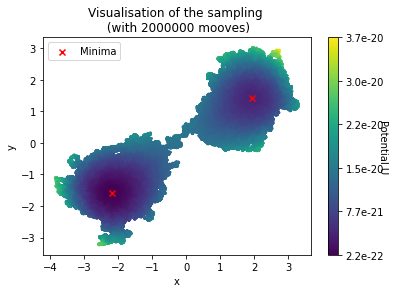

In [7]:
plt.scatter(x_list, y_list, c = U_list, s=3)
plt.scatter([x_list[min_ind_1],x_list[min_ind_2]], [y_list[min_ind_1],y_list[min_ind_2]], c = 'red', marker='x',label='Minima')

plt.xlabel('x')
plt.ylabel('y')
t = 'Visualisation of the sampling \n (with ' + str(Nbr_MC) + ' mooves)'
plt.title(t)
plt.legend()

cbar = plt.colorbar()

U_ticks = np.linspace(min(U_list), max(U_list), 6)
U_ticks = [str(U_ticks[i])[0:3] + str(U_ticks[i])[-4:] for i in range(len(U_ticks))]
cbar.ax.set_yticklabels(U_ticks)

cbar.set_label('Potential U', rotation=270)

print('Minimum 1 at (x,y) = (', x_list[min_ind_1],y_list[min_ind_1], ') with U = ', U_min_1, 'J')
print()
print('Minimum 2 at (x,y) = (', x_list[min_ind_2],y_list[min_ind_2], ') with U = ', U_min_2, 'J')

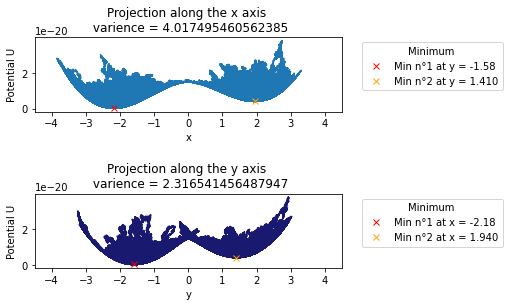

In [9]:
# Projection of the data along the x axisDimensionality
plt.subplot(211)

#Trajectory :
plt.plot(x_list, U_list)

#Indicates the mininmas:
MIN1_X = 'Min n¬∞1 at y = ' + str(y_list[min_ind_1])[0:5]
MIN2_X = 'Min n¬∞2 at y = ' + str(y_list[min_ind_2])[0:5]
plt.plot([x_list[min_ind_1]], [U_list[min_ind_1]],c = 'red', marker='x', linestyle='None',label= MIN1_X )
plt.plot([x_list[min_ind_2]], [U_list[min_ind_2]],c = 'orange', marker='x', linestyle='None',label= MIN2_X )

#Titles and labels for the plot :
t = 'Projection along the x axis \n varience = ' + str(np.var(x_list))
plt.title(t)
plt.xlim(-4.5, 4.5)
plt.xlabel('x')
plt.ylabel('Potential U')
plt.legend(title='Minimum ', bbox_to_anchor=(1.05, 1), loc='upper left')




# Projection of the data along the y axis
plt.subplot(212)

#Trajectory :
plt.plot(y_list, U_list, c = 'midnightblue')

#Indicates the mininmas:
MIN1_Y = 'Min n¬∞1 at x = ' + str(x_list[min_ind_1])[0:5]
MIN2_Y = 'Min n¬∞2 at x = ' + str(x_list[min_ind_2])[0:5]
plt.plot([y_list[min_ind_1]], [U_list[min_ind_1]],c = 'red', marker='x', linestyle='None',label= MIN1_Y )
plt.plot([y_list[min_ind_2]], [U_list[min_ind_2]],c = 'orange', marker='x', linestyle='None',label= MIN2_Y )

#Titles and labels for the plot :
t = 'Projection along the y axis \n varience = ' + str(np.var(y_list))
plt.title(t)
plt.xlim(-4.5, 4.5)
plt.xlabel('y')
plt.ylabel('Potential U')
plt.legend(title='Minimum ', bbox_to_anchor=(1.05, 1), loc='upper left')


#General adjustments :
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.show()

We can clearly see the two minimas in the two projections, both corrdinates hold information about the main characteristic of the energy surface. Alough the varience along x is 1.7 times larger then the one along y 

In [ ]:
it is describing only describing jjj % of the tatal varience of the system.

## Task III: Sampling

Free energy :
$$\Delta G(x,y) = -k_{b}T ln(P(x,y))$$
$$ = (U2-U1) = \Delta U$$

With :
    $$ln(P) = - \frac{(U2-U1)}{k_{b}T}$$
    
The plot will then show us the gradien of the energy surface. In the cell below we calculate the free energy $\Delta G$ for our trajectory.

In [10]:
lnP_list = [0]* Nbr_MC
for i in trange (1, Nbr_MC):
    U_1 = Potential_energy( x_list[i-1], y_list[i-1])
    U_2 = Potential_energy( x_list[i], y_list[i])
    lnP = abs((U_2 - U_1))
    lnP_list[i-1] = lnP

**Plot**

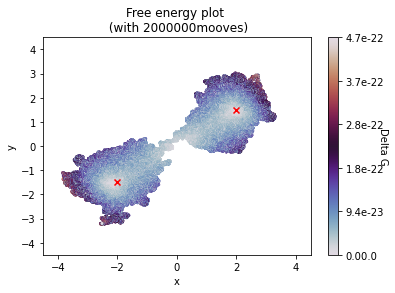

In [11]:
plt.scatter(x_list[1:], y_list[1:], c = lnP_list[:],cmap=plt.get_cmap('twilight'), s=3)
plt.scatter([2,-2], [1.5,-1.5], c = 'red', marker='x',label='Minima')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-4.5,4.5)
plt.ylim(-4.5,4.5)

t = 'Free energy plot \n (with ' + str(Nbr_MC) + 'mooves)'
plt.title(t)

cbar = plt.colorbar(cm.ScalarMappable( cmap='twilight'))

lnP_ticks = np.linspace(min(lnP_list), max(lnP_list), 6)
lnP_ticks = [str(lnP_ticks[i])[0:3] + str(lnP_ticks[i])[-4:] for i in range(len(lnP_ticks))]
cbar.ax.set_yticklabels(lnP_ticks)

cbar.set_label('Delta G', rotation=270)

The lighter areas are ones with the lowest free energy and correspondingly with the smallest potential gradient. We can see that the free energy is minimised around the area of minimum potential but also along the conecting pathay between them. Because the simulation was run using the metropolis algorhthm, the trajectory is more likely to follow a path with low gradient.

## Task IV: PCA

**Means**

In [12]:
mean_x = np.mean(x_list)
mean_y = np.mean(y_list)

**Variances**

In [13]:
var_x = np.var(x_list)
var_y = np.var(y_list)

**Covariances and matrix $\sigma_{ij}$**

$\sigma_{ij} = 
\begin{pmatrix}
var(x) & cov(x,y)\\
cov(y,x) & var(y)
\end{pmatrix}$

In [14]:
sigma = np.cov(x_list, y_list)
print('ùúé_ij =  \n',sigma)

ùúé_ij =  
 [[4.01749747 2.81880472]
 [2.81880472 2.31654261]]


**Eigenvalues $\lambda_{k}$ and eigenvectors $\vec{e}_{\lambda k}$**

In [33]:
eig_values, eig_vectors = np.linalg.eig(sigma)

eig_vec_1 = eig_vectors[:,0]
eig_val_1 = eig_values[0]
eig_vec_2 = eig_vectors[:,1]
eig_val_2 = eig_values[1]

print('Lambda1 = ', eig_val_1, 'with eigenvector e1: ', eig_vec_1)
print('Lambda2 = ', eig_val_2, 'with eigenvector e2: ',eig_vec_2)

n = np.sqrt((x_list[min_ind_2]-x_list[min_ind_1])**2 + (y_list[min_ind_2]-y_list[min_ind_1])**2)
v1= [(x_list[min_ind_2]-x_list[min_ind_1])/n,(y_list[min_ind_2]-y_list[min_ind_1])/n]
print('\n Unit vector connecting our two minimas : ',v1)

Lambda1 =  6.1113318329016835 with eigenvector e1:  [0.80276223 0.59629925]
Lambda2 =  0.22270825116709414 with eigenvector e2:  [-0.59629925  0.80276223]

 Unit vector connecting our two minimas :  [0.8088054040909834, 0.58807637115703]


The eigenvectors match the data as expected, as we can see that our first vector has the same direction as the connecting axis between the two minimas and that our second vector is perpendicular to the first our as expected.

## Task V: Interpretation

**Angle $\theta$ between the eigenvector $\vec{e}_{Œª1}$**

In [16]:
Theta = np.arctan(eig_vec_1[0]/eig_vec_1[1])
print('Theta ~', str(round(Theta/np.pi, 3)),'ùúã')

Theta ~ 0.297 ùúã


The angle $\theta$ found seems correct compared to the plot of the potential displayed in Task II.

**Clockwise rotation matrix R**

$R (\theta) = 
\begin{pmatrix}
Cos(\theta) & Sin(\theta)\\
-Sin(\theta) & Cos(\theta)
\end{pmatrix}$

$R \begin{pmatrix} x \\ y \end{pmatrix} = \begin{pmatrix} x' \\ y' \end{pmatrix}$

For $x'$ and $y'$ being the data in the rotated frame and x,y our initial data.

In [17]:
R = np.array([[np.cos(Theta), np.sin(Theta)],[- np.sin(Theta), np.cos(Theta)]])

**Calculate the data in the new frame**

In [18]:
x_rot_list = [R[0,0]*x_list[i] + R[0,1]*y_list[i] for i in trange(len(x_list))]
y_rot_list = [R[1,0]*x_list[i] + R[1,1]*y_list[i] for i in trange(len(x_list))]

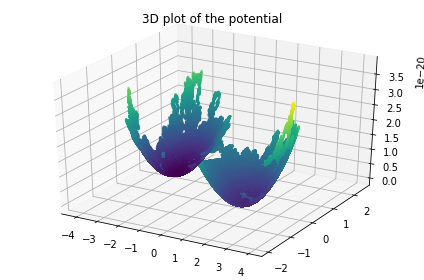

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.scatter(x_rot_list, y_rot_list, U_list, c=U_list, marker='o', s=2)

plt.title('3D plot of the potential')

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(U_ticks)

plt.tight_layout()
plt.show()

Minimum 1 at: (x,y) = ( -2.57 0.805 ) with U =  2.2978051441872487e-22

Minimum 2 at: (x,y) = ( 2.289 -0.71 ) with U =  4.075809248912603e-21


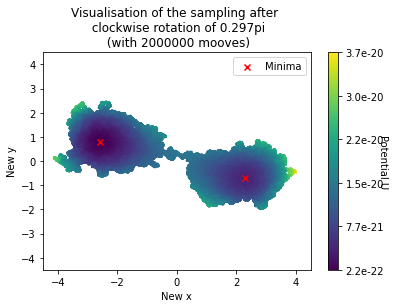

In [20]:
plt.scatter(x_rot_list, y_rot_list, c = U_list, s=3)
plt.scatter([x_rot_list[min_ind_1],x_rot_list[min_ind_2]], [y_rot_list[min_ind_1],y_rot_list[min_ind_2]], c = 'red', marker='x',label='Minima')

plt.xlabel('New x')
plt.ylabel('New y')
plt.xlim(-4.5,4.5)
plt.ylim(-4.5,4.5)

t = 'Visualisation of the sampling after \n clockwise rotation of ' + str(round(Theta/np.pi, 3)) + 'pi\n (with ' + str(Nbr_MC) + ' mooves)'
plt.title(t)
plt.legend()

cbar = plt.colorbar()

U_ticks = np.linspace(min(U_list), max(U_list), 6)
U_ticks = [str(U_ticks[i])[0:3] + str(U_ticks[i])[-4:] for i in range(len(U_ticks))]
cbar.ax.set_yticklabels(U_ticks)

cbar.set_label('Potential U', rotation=270)

print('Minimum 1 at: (x,y) = (', str(x_rot_list[min_ind_1])[0:5], str(y_rot_list[min_ind_1])[0:5], ') with U = ', U_min_1)
print()
print('Minimum 2 at: (x,y) = (', str(x_rot_list[min_ind_2])[0:5], str(y_rot_list[min_ind_2])[0:5], ') with U = ', U_min_2)

In [45]:
sigma_new = np.cov(x_rot_list, y_rot_list)
print('Previous covarience matrix : \n ùúé_ij =  \n',sigma)
v1 = sigma[0,0]+ sigma[1,1]
print('\n ',str(sigma[0,0]/v1*100)[0:4],'% of the varience of the total system is')
print('contained in x and ', str(sigma[1,1]/v1*100)[0:4],'% in y')

print()
print('New covarience matrix : \n ùúé_ij =  \n',sigma_new)
v2 = sigma_new[0,0]+ sigma_new[1,1]
print('\n ',str(sigma_new[0,0]/v2*100)[0:4],'% of the varience of the total system is')
print('contained in the new x coordinate and ', str(sigma_new[1,1]/v2*100)[0:4],'% in the new y')

Previous covarience matrix : 
 ùúé_ij =  
 [[4.01749747 2.81880472]
 [2.81880472 2.31654261]]

  63.4 % of the varience of the total system is
contained in x and  36.5 % in y

New covarience matrix : 
 ùúé_ij =  
 [[ 5.62000353 -1.62844832]
 [-1.62844832  0.71403655]]

  88.7 % of the varience of the total system is
contained in the new x coordinate and  11.2 % in the new y


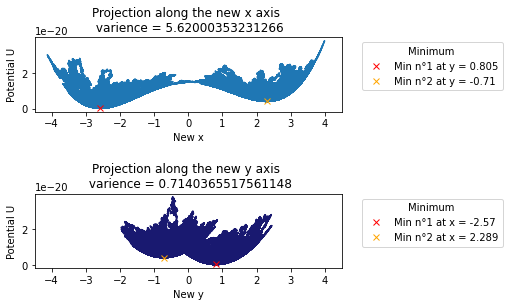

In [22]:
plt.subplot(211)
plt.plot(x_rot_list, U_list)

MIN1_X = 'Min n¬∞1 at y = ' + str(y_rot_list[min_ind_1])[0:5]
MIN2_X = 'Min n¬∞2 at y = ' + str(y_rot_list[min_ind_2])[0:5]
plt.plot([x_rot_list[min_ind_1]], [U_list[min_ind_1]],c = 'red', marker='x', linestyle='None',label= MIN1_X )
plt.plot([x_rot_list[min_ind_2]], [U_list[min_ind_2]],c = 'orange', marker='x', linestyle='None',label= MIN2_X )

t = 'Projection along the new x axis \n varience = ' + str(sigma_new[0,0])
plt.title(t)
plt.xlim(-4.5, 4.5)
plt.xlabel('New x')
plt.ylabel('Potential U')
plt.legend(title='Minimum ', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(212)
plt.plot(y_rot_list, U_list, c = 'midnightblue')

MIN1_Y = 'Min n¬∞1 at x = ' + str(x_rot_list[min_ind_1])[0:5]
MIN2_Y = 'Min n¬∞2 at x = ' + str(x_rot_list[min_ind_2])[0:5]
plt.plot([y_rot_list[min_ind_1]], [U_list[min_ind_1]],c = 'red', marker='x', linestyle='None',label= MIN1_Y )
plt.plot([y_rot_list[min_ind_2]], [U_list[min_ind_2]],c = 'orange', marker='x', linestyle='None',label= MIN2_Y )

t = 'Projection along the new y axis \n varience = ' + str(sigma_new[1,1])
plt.title(t)
plt.xlim(-4.5, 4.5)
plt.xlabel('New y')
plt.ylabel('Potential U')
plt.legend(title='Minimum ', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.show()

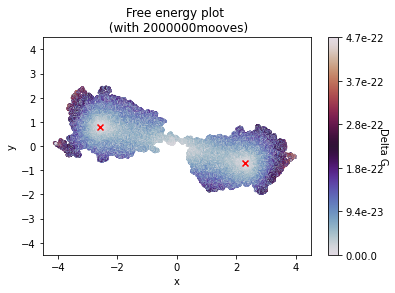

In [23]:
plt.scatter(x_rot_list[1:], y_rot_list[1:], c = lnP_list[:],cmap=plt.get_cmap('twilight'), s=3)
plt.scatter([x_rot_list[min_ind_1],x_rot_list[min_ind_2]], [y_rot_list[min_ind_1],y_rot_list[min_ind_2]], c = 'red', marker='x',label='Minima')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-4.5,4.5)
plt.ylim(-4.5,4.5)

t = 'Free energy plot \n (with ' + str(Nbr_MC) + 'mooves)'
plt.title(t)

cbar = plt.colorbar(cm.ScalarMappable( cmap='twilight'))

lnP_ticks = np.linspace(min(lnP_list), max(lnP_list), 6)
lnP_ticks = [str(lnP_ticks[i])[0:3] + str(lnP_ticks[i])[-4:] for i in range(len(lnP_ticks))]
cbar.ax.set_yticklabels(lnP_ticks)

cbar.set_label('Delta G', rotation=270)

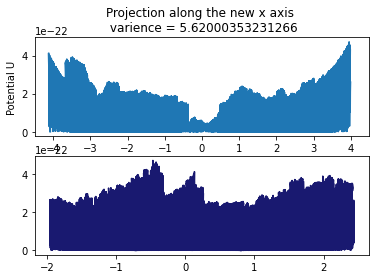

In [24]:
plt.subplot(211)
plt.plot(x_rot_list[0:-1], lnP_list)

'''
MIN1_X = 'Min n¬∞1 at y = ' + str(y_rot_list[min_ind_1])[0:5]
MIN2_X = 'Min n¬∞2 at y = ' + str(y_rot_list[min_ind_2])[0:5]
plt.plot([x_rot_list[min_ind_1]], [U_list[min_ind_1]],c = 'red', marker='x',label= MIN1_X )
plt.plot([x_rot_list[min_ind_2]], [U_list[min_ind_2]],c = 'orange', marker='x',label= MIN2_X )
'''
t = 'Projection along the new x axis \n varience = ' + str(sigma_new[0,0])
plt.title(t)
plt.xlim(-4.5, 4.5)
plt.xlabel('New x')
plt.ylabel('Potential U')
#plt.legend(title='Minimum ', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(212)
plt.plot(y_rot_list[0:-1], lnP_list, c = 'midnightblue')


From the covarience matrix and from the above plot of the data along our new x and y axis we can clearly see that most of the varience is not contained in the first componant x (88% of the varience in contrast to 63% previously).

* "the histogram of Task III" is it not a plot that we are expecting? 
* $\Delta G$ equivalent to U ???
* add comments on the percentages
* V ?
* interpretation
* Intro

Expected percentages of varience in the intro